In [2]:
#main
import pandas as pd
import numpy as np

#plot
from matplotlib import pyplot as plt
import seaborn as sns

#dop
import re
from tqdm import tqdm
from tqdm.notebook import tqdm
tqdm.pandas()
from IPython.display import display
from datetime import datetime, timedelta, date, time

#prepprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

#ML
from sklearn.linear_model import LogisticRegression

#metrics 
from sklearn.metrics import roc_auc_score

# option
pd.set_option("display.max_columns", 300)
plt.rcParams['figure.figsize'] = (15, 10)

PATH_TRAIN = 'data/train.csv'
PATH_TASK = 'data/test.csv'
TARGET_COL = 'target'

In [3]:
time_col = ['time' + str(i) for i in range(1, 11)]

train = pd.read_csv(PATH_TRAIN, parse_dates=time_col, index_col='session_id')
task = pd.read_csv(PATH_TASK, parse_dates=time_col, index_col='session_id')
y_train_full = train[[TARGET_COL]]
df = pd.concat([train.drop(TARGET_COL, axis=1), task], ignore_index=True)

print(train.shape, task.shape)
print('-'*50)
df.info()
df.head()

(253561, 21) (82797, 20)
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336358 entries, 0 to 336357
Data columns (total 20 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   site1   336358 non-null  int64         
 1   time1   336358 non-null  datetime64[ns]
 2   site2   331406 non-null  float64       
 3   time2   331406 non-null  datetime64[ns]
 4   site3   326994 non-null  float64       
 5   time3   326994 non-null  datetime64[ns]
 6   site4   323503 non-null  float64       
 7   time4   323503 non-null  datetime64[ns]
 8   site5   320170 non-null  float64       
 9   time5   320170 non-null  datetime64[ns]
 10  site6   317061 non-null  float64       
 11  time6   317061 non-null  datetime64[ns]
 12  site7   314137 non-null  float64       
 13  time7   314137 non-null  datetime64[ns]
 14  site8   311375 non-null  float64       
 15  time8   311375 non-null  datetime64[ns]
 16

site1               time1  site2               time2    site3  \
0    718 2014-02-20 10:02:45    NaN                 NaT      NaN   
1    890 2014-02-22 11:19:50  941.0 2014-02-22 11:19:50   3847.0   
2  14769 2013-12-16 16:40:17   39.0 2013-12-16 16:40:18  14768.0   
3    782 2014-03-28 10:52:12  782.0 2014-03-28 10:52:42    782.0   
4     22 2014-02-28 10:53:05  177.0 2014-02-28 10:55:22    175.0   

                time3    site4               time4  site5               time5  \
0                 NaT      NaN                 NaT    NaN                 NaT   
1 2014-02-22 11:19:51    941.0 2014-02-22 11:19:51  942.0 2014-02-22 11:19:51   
2 2013-12-16 16:40:19  14769.0 2013-12-16 16:40:19   37.0 2013-12-16 16:40:19   
3 2014-03-28 10:53:12    782.0 2014-03-28 10:53:42  782.0 2014-03-28 10:54:12   
4 2014-02-28 10:55:22    178.0 2014-02-28 10:55:23  177.0 2014-02-28 10:55:23   

    site6               time6    site7               time7    site8  \
0     NaN                 NaT      NaN                 NaT      NaN   
1  3846.0 2014-02-22 11:19:51   3847.0 2014-02-22 11:19:52   3846.0   
2    39.0 2013-12-16 16:40:19  14768.0 2013-12-16 16:40:20  14768.0   
3   782.0 2014-03-28 10:54:42    782.0 2014-03-28 10:55:12    782.0   
4   178.0 2014-02-28 10:55:59    175.0 2014-02-28 10:55:59    177.0   

                time8    site9               time9   site10  \
0                 NaT      NaN                 NaT      NaN   
1 2014-02-22 11:19:52   1516.0 2014-02-22 11:20:15   1518.0   
2 2013-12-16 16:40:21  14768.0 2013-12-16 16:40:22  14768.0   
3 2014-03-28 10:55:42    782.0 2014-03-28 10:56:12    782.0   
4 2014-02-28 10:55:59    177.0 2014-02-28 10:57:06    178.0   

               time10  
0                 NaT  
1 2014-02-22 11:20:16  
2 2013-12-16 16:40:24  
3 2014-03-28 10:56:42  
4 2014-02-28 10:57:11

In [4]:
train['target'].value_counts()

0    251264
1      2297
Name: target, dtype: int64

In [5]:
def start_in_seconds(x):
    if type(x) != pd._libs.tslibs.nattype.NaTType:
        return pd.to_timedelta(str(x.time())) // np.timedelta64(1, 's')
    else:
        return -1


def feature_engineering(df, time_col):
    df_time = df[time_col].copy()
    
    print('Обработка: mounth')
    df_time['month'] = df_time[time_col[0]].progress_apply(lambda x: x.date().month)
    
    print('Обработка: weekday')
    df_time['weekday'] = df_time[time_col[0]].progress_apply(lambda x: x.weekday()) 
    
    print('Обработка: time1')
    df_time[time_col[0] + '_sec'] = df_time[time_col[0]].progress_apply(start_in_seconds)
    
    print('Обработка: Разницы')
    col_diff = []
    for i in tqdm(range(len(time_col) - 1)):
        df_time[time_col[i + 1]+'-'+time_col[i]] = (df[time_col[i + 1]] - df[time_col[i]]) // np.timedelta64(1, 's')
        col_diff.append(time_col[i + 1]+'-'+time_col[i])
    df_time[col_diff] = df_time[col_diff].fillna(0)
    
    df_time['session_len'] = df_time[col_diff].sum(axis=1)
    df_time['mean_session_len'] = df_time[col_diff].mean(axis=1)
    
    df_time.drop(columns=time_col, axis=1, inplace=True)
    df_time['target'] = df['target']
    return df_time

In [6]:
df_time = feature_engineering(train, time_col)

Обработка: mounth


  0%|          | 0/253561 [00:00<?, ?it/s]

Обработка: weekday


  0%|          | 0/253561 [00:00<?, ?it/s]

Обработка: time1


  0%|          | 0/253561 [00:00<?, ?it/s]

Обработка: Разницы


  0%|          | 0/9 [00:00<?, ?it/s]

In [7]:
df_time[df_time['target'] == 1]['weekday'].value_counts()

0    1315
1     526
4     308
3     110
2      38
Name: weekday, dtype: int64

In [8]:
np.timedelta64(30, 'm') // np.timedelta64(1, 's')

1800

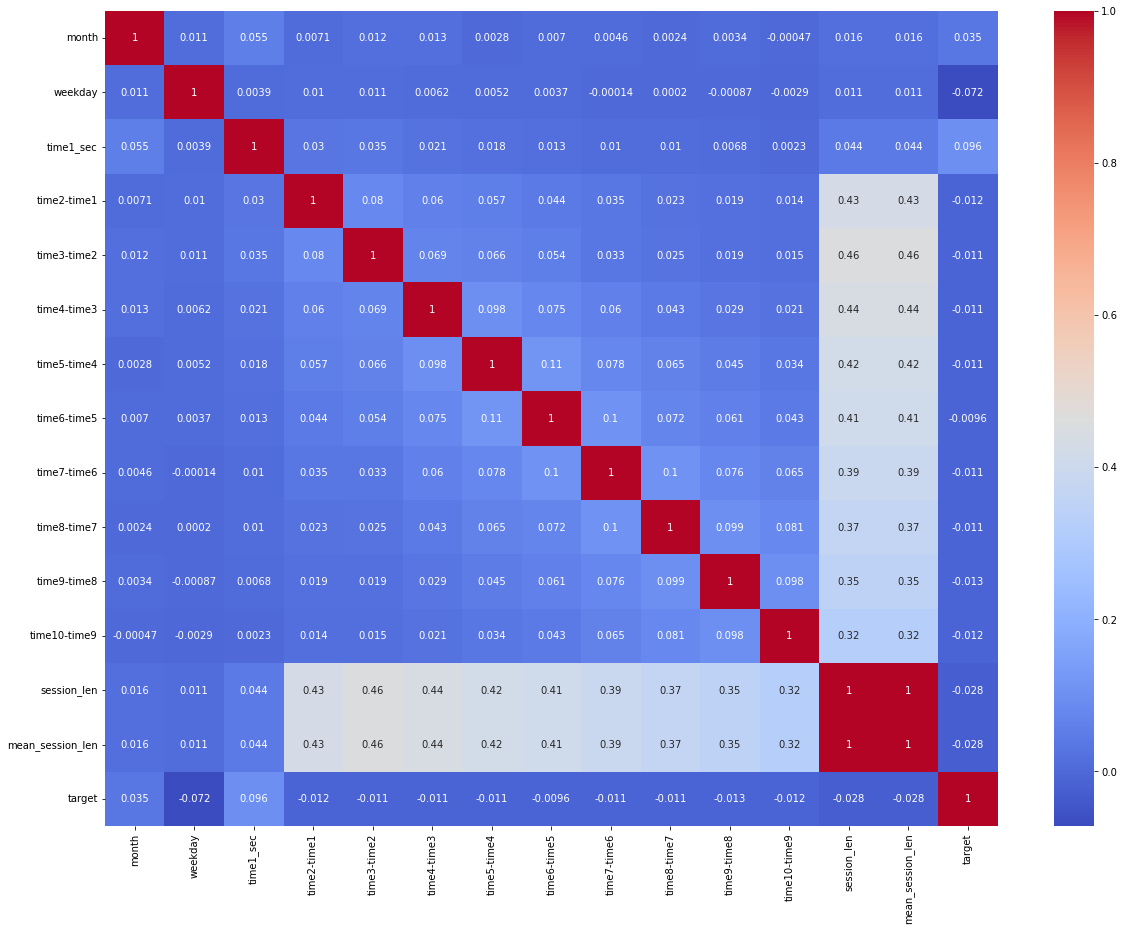

In [9]:
plt.figure(figsize=[20,15])
sns.heatmap(df_time.corr(), annot=True, cmap='coolwarm')
plt.show()

In [10]:
df_time.groupby(by='target').mean()

month   weekday     time1_sec  time2-time1  time3-time2  \
target                                                               
0       5.250728  2.089834  45916.236815    19.050998    19.173499   
1       6.804092  0.942098  57364.195037     6.389639     6.830213   

        time4-time3  time5-time4  time6-time5  time7-time6  time8-time7  \
target                                                                    
0         17.372457    15.240532    14.688411    14.063682    13.457133   
1          6.437963     5.818024     7.013061     5.908576     5.679582   

        time9-time8  time10-time9  session_len  mean_session_len  
target                                                            
0         13.305440     12.930221   139.282372         15.475819  
1          3.986069      4.233348    52.296474          5.810719

# interim prediction

In [11]:
def get_auc_lr_valid(x, y, C=1.0, seed=17, ratio = 0.9):
    
    ss = StandardScaler()
    x = ss.fit_transform(x)
    # Split the data into the training and validation sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=(1 - ratio),  random_state=seed)
    
    # Classifier training
    lr = LogisticRegression(C=C, random_state=seed, solver='lbfgs', max_iter=500).fit(x_train, y_train)
    
    # Prediction for validation set
    y_pred = lr.predict_proba(x_test)[:, 1]
    
    # Calculate the quality
    score = roc_auc_score(y_test, y_pred)
    
    return score

In [35]:
df_test = df_time[['month', 'weekday', 'time1_sec', 'session_len', 'mean_session_len']]

In [13]:
print(get_auc_lr_valid(df_test, y_train_full))

C:\Users\79214\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.8352889702080267


In [14]:
train['target'].value_counts() / train.shape[0]

0    0.990941
1    0.009059
Name: target, dtype: float64

In [15]:
train[train['site10'].isna()]

site1               time1    site2               time2   site3  \
session_id                                                                   
1             718 2014-02-20 10:02:45      NaN                 NaT     NaN   
6             570 2014-03-18 15:18:31     21.0 2014-03-18 15:18:39   570.0   
22             21 2014-04-02 09:59:41     21.0 2014-04-02 09:59:55    22.0   
24            812 2013-12-12 20:51:18      NaN                 NaT     NaN   
30           2740 2014-04-15 14:55:40    262.0 2014-04-15 14:55:41   539.0   
...           ...                 ...      ...                 ...     ...   
253527        961 2013-12-04 12:16:49      NaN                 NaT     NaN   
253538        306 2014-04-02 13:59:54     56.0 2014-04-02 14:03:58    55.0   
253545       6003 2014-04-20 17:21:48   6003.0 2014-04-20 17:21:49  6003.0   
253551       1039 2014-03-26 14:11:42    812.0 2014-03-26 14:21:17  1039.0   
253559       2661 2013-12-09 14:05:03  15004.0 2013-12-09 14:05:10  5562.0   

                         time3   site4               time4   site5  \
session_id                                                           
1                          NaT     NaN                 NaT     NaN   
6          2014-03-18 15:23:02    21.0 2014-03-18 15:23:43    21.0   
22         2014-04-02 09:59:56    23.0 2014-04-02 09:59:58    22.0   
24                         NaT     NaN                 NaT     NaN   
30         2014-04-15 14:55:42   322.0 2014-04-15 14:55:42   148.0   
...                        ...     ...                 ...     ...   
253527                     NaT     NaN                 NaT     NaN   
253538     2014-04-02 14:03:58     NaN                 NaT     NaN   
253545     2014-04-20 17:21:51  6003.0 2014-04-20 17:21:54  6003.0   
253551     2014-03-26 14:23:57   774.0 2014-03-26 14:25:17  1039.0   
253559     2013-12-09 14:05:10  5562.0 2013-12-09 14:06:29  5562.0   

                         time5   site6               time6   site7  \
session_id                                                           
1                          NaT     NaN                 NaT     NaN   
6          2014-03-18 15:29:57     NaN                 NaT     NaN   
22         2014-04-02 10:00:56    21.0 2014-04-02 10:00:56    21.0   
24                         NaT     NaN                 NaT     NaN   
30         2014-04-15 14:55:43   539.0 2014-04-15 14:55:43   293.0   
...                        ...     ...                 ...     ...   
253527                     NaT     NaN                 NaT     NaN   
253538                     NaT     NaN                 NaT     NaN   
253545     2014-04-20 17:21:57  6003.0 2014-04-20 17:21:59  6003.0   
253551     2014-03-26 14:27:57   774.0 2014-03-26 14:35:40  1039.0   
253559     2013-12-09 14:06:30     NaN                 NaT     NaN   

                         time7   site8               time8   site9  \
session_id                                                           
1                          NaT     NaN                 NaT     NaN   
6                          NaT     NaN                 NaT     NaN   
22         2014-04-02 10:00:57    23.0 2014-04-02 10:00:57    63.0   
24                         NaT     NaN                 NaT     NaN   
30         2014-04-15 14:55:43     NaN                 NaT     NaN   
...                        ...     ...                 ...     ...   
253527                     NaT     NaN                 NaT     NaN   
253538                     NaT     NaN                 NaT     NaN   
253545     2014-04-20 17:22:01  6003.0 2014-04-20 17:22:05  6003.0   
253551     2014-03-26 14:35:42   774.0 2014-03-26 14:39:41  1039.0   
253559                     NaT     NaN                 NaT     NaN   

                         time9  site10 time10  target  
session_id                                             
1                          NaT     NaN    NaT       0  
6                          NaT     NaN    NaT       0  
22         2014-04-02 10:02:48     NaN  

<AxesSubplot:xlabel='month', ylabel='count'>

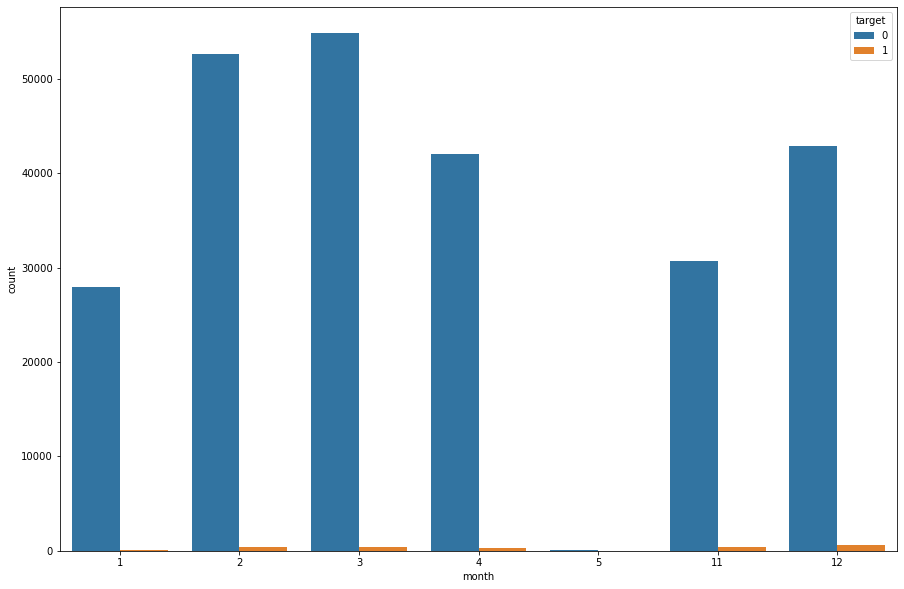

In [16]:
sns.countplot(x='month', hue = 'target', data = df_time)

In [18]:
df_time.columns

Index(['month', 'weekday', 'time1_sec', 'time2-time1', 'time3-time2',
       'time4-time3', 'time5-time4', 'time6-time5', 'time7-time6',
       'time8-time7', 'time9-time8', 'time10-time9', 'session_len',
       'mean_session_len', 'target'],
      dtype='object')

C:\Users\79214\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


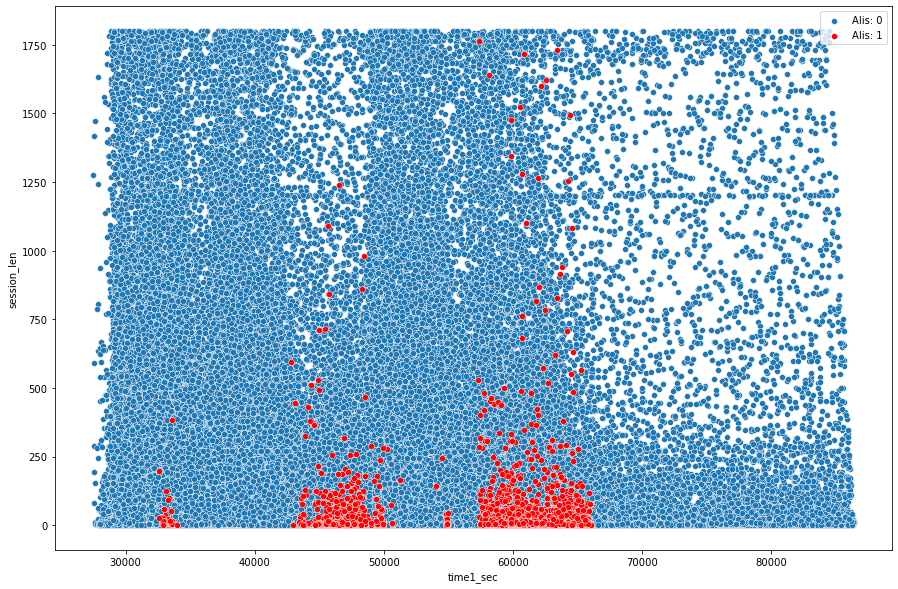

In [38]:
sns.scatterplot(x='time1_sec', y='session_len', data=df_time[df_time['target'] == 0])
sns.scatterplot(x='time1_sec', y='session_len', data=df_time[df_time['target'] == 1], color='red')
plt.legend(['Alis: 0', 'Alis: 1'])
plt.show()

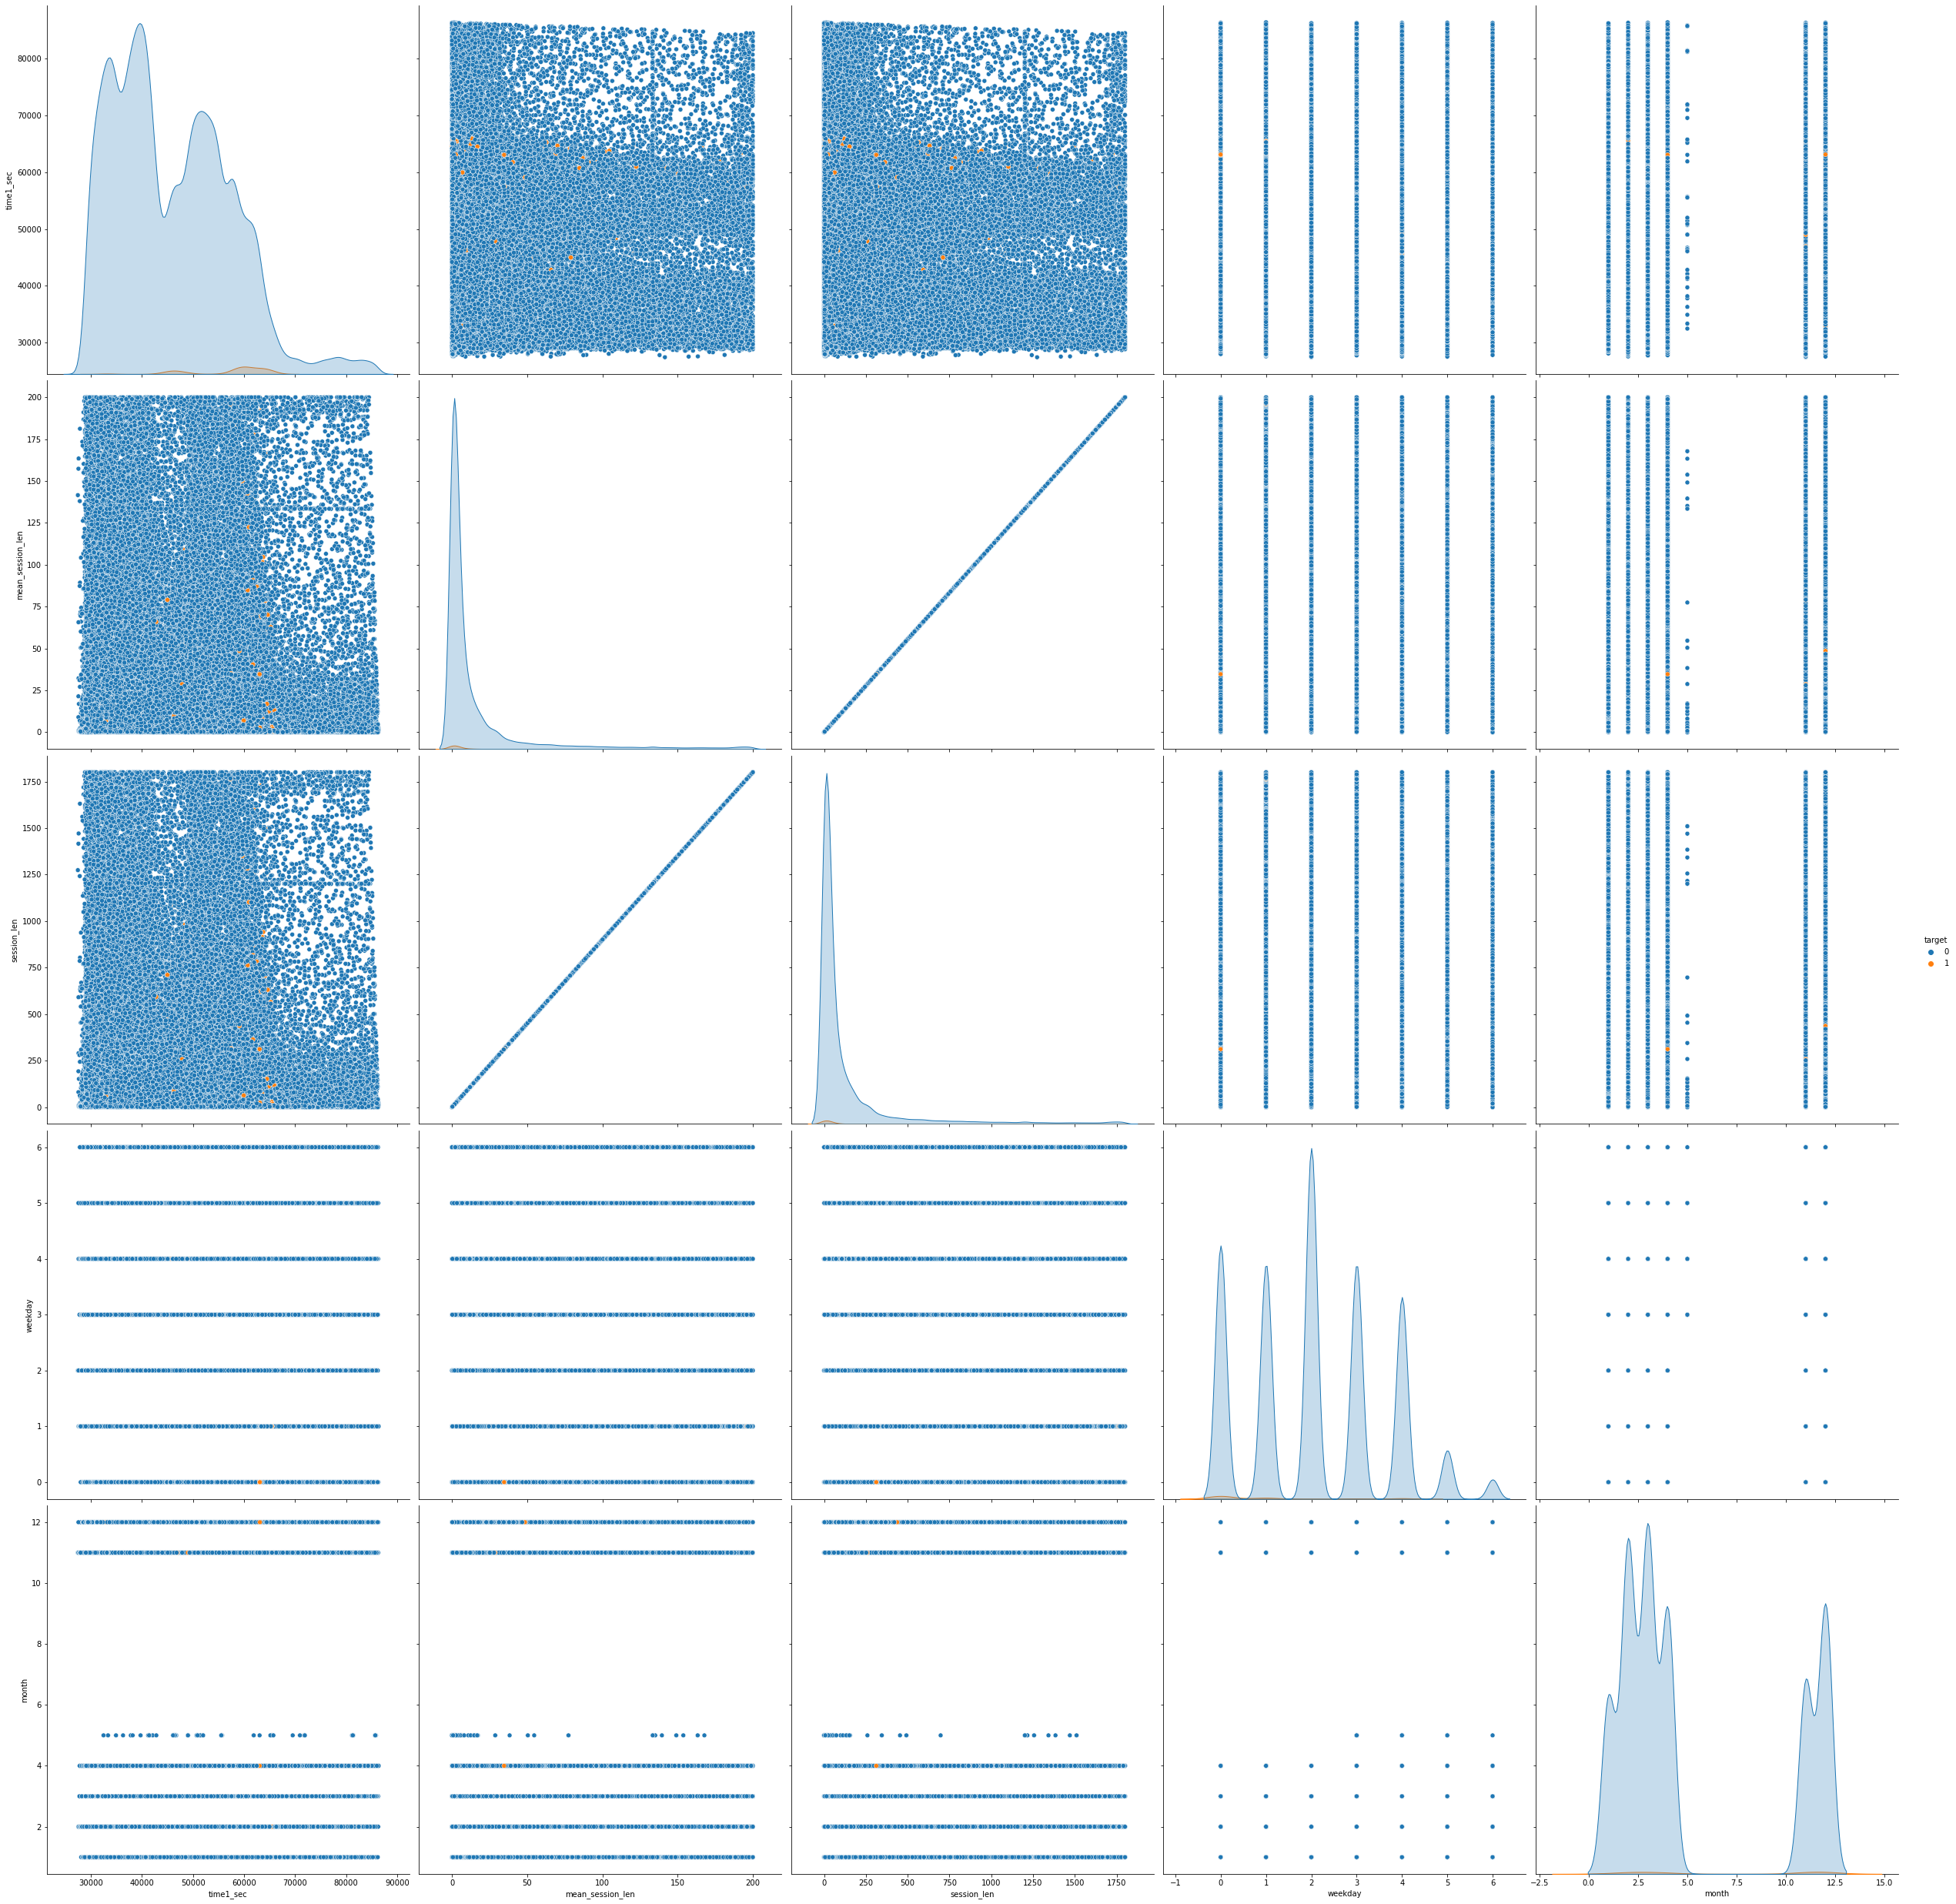

In [25]:
sns.pairplot(df_time[['time1_sec', 'mean_session_len', 'session_len', 'weekday', 'month', 'target']], hue="target", height=7)
plt.show()

In [40]:
df_test = df_time[['month', 'weekday', 'time1_sec', 'session_len', 'mean_session_len']]

In [63]:
df_time['time1_sec'].min()

27444

In [41]:
df_test.loc[:,'time1_sec'] = df_test['time1_sec'] + 86399 - df_time[df_time['target'] == 1]['time1_sec'].max()
df_test.loc[:,'time1_sec'] = df_test['time1_sec'].progress_apply(lambda x: x - 86399 + 27444 if x > 86400 else x)

C:\Users\79214\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


  0%|          | 0/253561 [00:00<?, ?it/s]

C:\Users\79214\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


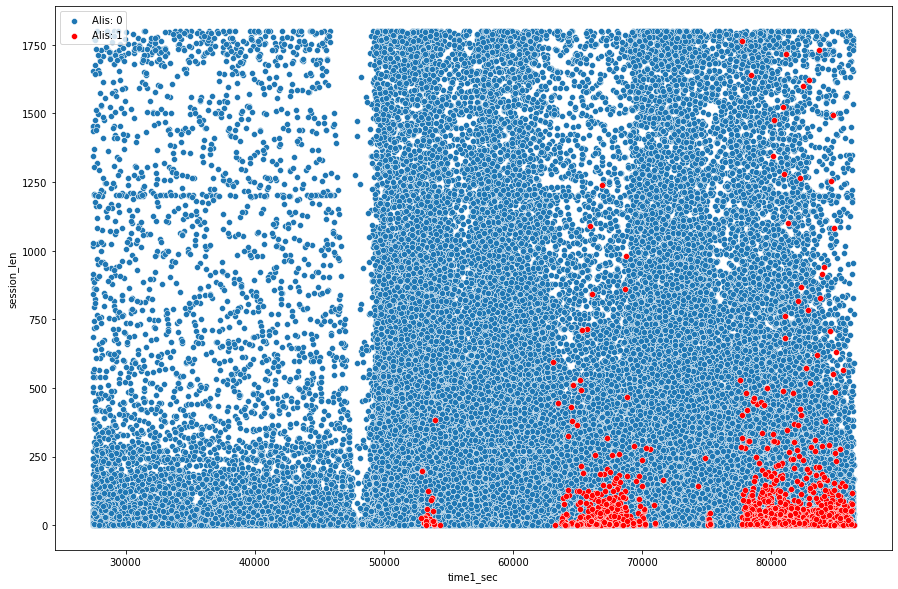

In [42]:
sns.scatterplot(x='time1_sec', y='session_len', data=df_test[df_time['target'] == 0])
sns.scatterplot(x='time1_sec', y='session_len', data=df_test[df_time['target'] == 1], color='red')
plt.legend(['Alis: 0', 'Alis: 1'])
plt.show()

In [43]:
print(get_auc_lr_valid(df_test, y_train_full))

C:\Users\79214\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.8711866922409464


In [52]:
df_test.loc[:,'weekday'] = df_test['weekday'].astype('object')
df_test.loc[:,'month'] = df_test['month'].astype('object')

C:\Users\79214\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [59]:
df_test = pd.get_dummies(df_test)

In [60]:
print(get_auc_lr_valid(df_test, y_train_full))

C:\Users\79214\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.9031956064094802


In [74]:
def start_in_seconds(x):
    if type(x) != pd._libs.tslibs.nattype.NaTType:
        return pd.to_timedelta(str(x.time())) // np.timedelta64(1, 's')
    else:
        return -1


def feature_engineering(df,
                        time_col,
                        target=True,
                        time_max=66054,
                        time_min=27444
                       ):
    df_time = df[time_col].copy()
    
    print('Обработка: mounth')
    df_time['month'] = df_time[time_col[0]].progress_apply(lambda x: x.date().month)
    
    print('Обработка: weekday')
    df_time['weekday'] = df_time[time_col[0]].progress_apply(lambda x: x.weekday()) 
    
    print('Обработка: time1')
    df_time[time_col[0] + '_sec'] = df_time[time_col[0]].progress_apply(start_in_seconds)
    
    print('Обработка: Разницы')
    col_diff = []
    for i in tqdm(range(len(time_col) - 1)):
        df_time[time_col[i + 1]+'-'+time_col[i]] = (df[time_col[i + 1]] - df[time_col[i]]) // np.timedelta64(1, 's')
        col_diff.append(time_col[i + 1]+'-'+time_col[i])
    df_time[col_diff] = df_time[col_diff].fillna(0)
    df_time['session_len'] = df_time[col_diff].sum(axis=1)
    df_time['mean_session_len'] = df_time[col_diff].mean(axis=1)
    
    print('Обработка: смещения')
    df_time.loc[:,'time1_sec'] = df_time['time1_sec'] + 86399 - time_max
    df_time.loc[:,'time1_sec'] = df_time['time1_sec'].progress_apply(lambda x: x - 86399 + time_min if x > 86400 else x)
    
    df_time['month'] = df_time['month'].astype('object')
    df_time['weekday'] = df_time['weekday'].astype('object')
    
    df_time = pd.get_dummies(df_time)
    if not target:
        df_time['month_11'] = 0
        df_time['month_12'] = 0
        
    if target:
        df_time['target'] = df['target']
    
    df_time.drop(columns=col_diff, axis=1, inplace=True)
    df_time.drop(columns=time_col, axis=1, inplace=True)
    
    print('-'*50)
    print(' '*22 + 'READY')
    print('-'*50)
    
    return df_time

In [75]:
train_change = feature_engineering(train, time_col, target=True)
train_change

Обработка: mounth


  0%|          | 0/253561 [00:00<?, ?it/s]

Обработка: weekday


  0%|          | 0/253561 [00:00<?, ?it/s]

Обработка: time1


  0%|          | 0/253561 [00:00<?, ?it/s]

Обработка: Разницы


  0%|          | 0/9 [00:00<?, ?it/s]

Обработка: смещения


  0%|          | 0/253561 [00:00<?, ?it/s]

--------------------------------------------------
                      READY
--------------------------------------------------


time1_sec  session_len  mean_session_len  month_1  month_2  \
session_id                                                               
1               56510          0.0          0.000000        0        1   
2               61135         26.0          2.888889        0        1   
3               80362          7.0          0.777778        0        0   
4               59477        270.0         30.000000        0        0   
5               59530        246.0         27.333333        0        1   
...               ...          ...               ...      ...      ...   
253557          57959         59.0          6.555556        0        0   
253558          78020          3.0          0.333333        0        0   
253559          71048         87.0          9.666667        0        0   
253560          75567          2.0          0.222222        0        0   
253561          56157          3.0          0.333333        0        0   

            month_3  month_4  month_5  month_11  month_12  weekday_0  \
session_id                                                             
1                 0        0        0         0         0          0   
2                 0        0        0         0         0          0   
3                 0        0        0         0         1          1   
4                 1        0        0         0         0          0   
5                 0        0        0         0         0          0   
...             ...      ...      ...       ...       ...        ...   
253557            0        0        0         1         0          1   
253558            0        0        0         0         1          0   
253559            0        0        0         0         1          1   
253560            0        0        0         0         1          0   
253561            0        1        0         0         0          0   

            weekday_1  weekday_2  weekday_3  weekday_4  weekday_5  weekday_6  \
session_id                                                                     
1                   0          0          1          0          0          0   
2                   0          0          0          0          1          0   
3                   0          0          0          0          0          0   
4                   0          0          0          1          0          0   
5                   0          0          0          1          0          0   
...               ...        ...        ...        ...        ...        ...   
253557              0          0          0          0          0          0   
253558              1          0          0          0          0          0   
253559              0          0          0          0          0          0   
253560              0          0          1          0          0          0   
253561              0          0          0          1          0          0   

            target  
session_id          
1                0  
2                0  
3                0  
4                0  
5                0  
...            ...  
253557           0  
253558           0  
253559           0  
253560           0  
253561           0  

[253561 rows x 18 columns]

---